In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlhep2021-classification/classification_example.csv
/kaggle/input/mlhep2021-classification/MLHEP-2021-train.tar.xz
/kaggle/input/mlhep2021-classification/MLHEP-2021-test.tar.xz


I like to get my hands dirty, so I started from importing the only CSV file in the dataset.

In [2]:
classification_example = pd.read_csv("/kaggle/input/mlhep2021-classification/classification_example.csv")

In [3]:
classification_example.head()

,id,particle
0,9a8b8bfc7a06afd346ff1c88f1f7a03316a9bc76,0.374540
1,2caa5748f814bbdbc64f4db43d7412ce359a777b,0.950714
2,b879970a23fc2a3b093bce85096808f13eaa69fb,0.731994
3,a4d3cb5abbdc11518bb67ae7f2c415de808effb3,0.598658
4,df8de9207196305057f73cea03d265ba720cb6e1,0.156019


Okay, so this `classification_example` thing is just an example of how the answer should look like. Fine.

Let's extract the training data.

In [4]:
os.system("tar -xvf /kaggle/input/mlhep2021-classification/MLHEP-2021-train.tar.xz")

0

Test extracting image file from .png format.

In [5]:
import imageio

im = imageio.imread('/kaggle/working/train/ER/0.6178290247917175__CYGNO_60_40_ER_30_keV_930V_30cm_IDAO_iso_crop_hist_pic_run3_ev288;1.png')
print(im.shape)

(576, 576)


Fetching data with different values of energies with `glob`.

In [6]:
import glob
glob.glob("/kaggle/working/train/ER/*10_keV*.png")[:5]

['/kaggle/working/train/ER/-0.34168174862861633__CYGNO_60_40_ER_10_keV_930V_30cm_IDAO_iso_crop_hist_pic_run3_ev406;1.png',
 '/kaggle/working/train/ER/0.09184857457876205__CYGNO_60_40_ER_10_keV_930V_30cm_IDAO_iso_crop_hist_pic_run2_ev258;1.png',
 '/kaggle/working/train/ER/1.213898777961731__CYGNO_60_40_ER_10_keV_930V_30cm_IDAO_iso_crop_hist_pic_run1_ev428;1.png',
 '/kaggle/working/train/ER/-0.6587756276130676__CYGNO_60_40_ER_10_keV_930V_30cm_IDAO_iso_crop_hist_pic_run3_ev460;1.png',
 '/kaggle/working/train/ER/-0.5403286814689636__CYGNO_60_40_ER_10_keV_930V_30cm_IDAO_iso_crop_hist_pic_run1_ev564;1.png']

In [7]:
glob.glob("/kaggle/working/train/NR/*1_keV*.png")[:5]

['/kaggle/working/train/NR/0.094200000166893__CYGNO_60_40_He_NR_1_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run2_ev126;1.png',
 '/kaggle/working/train/NR/1.3284000158309937__CYGNO_60_40_He_NR_1_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run5_ev807;1.png',
 '/kaggle/working/train/NR/-2.0678999423980713__CYGNO_60_40_He_NR_1_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run4_ev429;1.png',
 '/kaggle/working/train/NR/1.5687999725341797__CYGNO_60_40_He_NR_1_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run5_ev128;1.png',
 '/kaggle/working/train/NR/-1.2714999914169312__CYGNO_60_40_He_NR_1_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run4_ev922;1.png']

And here I extracted the matrices from all training dataset. For this iteration, data will be separated based on the energy of the recoil.
- ER: 3, 10, and 30 keV
- NR: 1, 6, and 20 keV

In [8]:
import skimage.restoration
import tqdm
ER_images_raw = {}
NR_images_raw = {}
for label in ["3_keV", "10_keV", "30_keV"]:
    ER_images_raw[label] = []
    for imgpath in tqdm.tqdm(glob.glob(f"/kaggle/working/train/ER/*{label}*.png")):
        image = imageio.imread(imgpath)
        #image = skimage.restoration.denoise_bilateral(image)
        ER_images_raw[label].append(image)
for label in ["1_keV", "6_keV", "20_keV"]:
    NR_images_raw[label] = []
    for imgpath in tqdm.tqdm(glob.glob(f"/kaggle/working/train/NR/*{label}*.png")):
        image = imageio.imread(imgpath)
        #image = skimage.restoration.denoise_bilateral(image)
        NR_images_raw[label].append(image)

100%|██████████| 2208/2208 [00:09<00:00, 239.62it/s]


Fun fact: Yesterday was my birthday.

In [9]:
for key in ER_images_raw.keys():
    ER_images_raw[key] = np.asarray(ER_images_raw[key])
for key in NR_images_raw.keys():
    NR_images_raw[key] = np.asarray(NR_images_raw[key])

In [10]:
print("Electron recoil (ER)")
for key in ER_images_raw.keys():
    print(key, ER_images_raw[key].shape)
print("Helium nucleus recoil (NR))")
for key in NR_images_raw.keys():
    print(key, NR_images_raw[key].shape)

Electron recoil (ER)
3_keV (2243, 576, 576)
10_keV (2272, 576, 576)
30_keV (2237, 576, 576)
Helium nucleus recoil (NR))
1_keV (2177, 576, 576)
6_keV (2255, 576, 576)
20_keV (2208, 576, 576)


Some preprocessing. Mainly I am reducing the image from 576x576 pixels to 36x36 pixels, but no normalisation yet.

In [11]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing
import skimage.measure

ER_images = {}
NR_images = {}
ER_images_zoomed1 = {}
NR_images_zoomed1 = {}
ER_images_zoomed2 = {}
NR_images_zoomed2 = {}

for imagerawcoll, imagecoll, imagezoomedcoll1, imagezoomedcoll2 in zip([ER_images_raw, NR_images_raw], \
                                                    [ER_images, NR_images], [ER_images_zoomed1, NR_images_zoomed1], \
                                                    [ER_images_zoomed2, NR_images_zoomed2]):
    for key in imagerawcoll.keys():
        imagecoll[key] = imagerawcoll[key][:, 228:348, 228:348]
        #imagecoll[key] = skimage.measure.block_reduce(imagecoll[key], block_size=(1, 18, 18), func=np.mean)
        #imagezoomedcoll1[key] = imagerawcoll[key][:, 192:384, 192:384]
        #imagezoomedcoll1[key] = skimage.measure.block_reduce(imagezoomedcoll1[key], block_size=(1, 6, 6), func=np.mean)
        #imagezoomedcoll2[key] = imagerawcoll[key][:, 256:320, 256:320]
        #imagezoomedcoll2[key] = skimage.measure.block_reduce(imagezoomedcoll2[key], block_size=(1, 2, 2), func=np.mean)
        #imagezoomedcoll2[key] = skimage.measure.block_reduce(imagezoomedcoll2[key], block_size=(1, 2, 2), func=np.mean)
        #magezoomedcoll[key] = skimage.measure.block_reduce(imagezoomedcoll[key], block_size=(1, 6, 6), func=np.zoomed)
        #ER_images[key] = ER_images[key][:, 144-50:144+50, 144-50:144+50]

In [12]:
print("Electron recoil (ER)")
for key in ER_images.keys():
    #print(key, ER_images[key].shape, ER_images_zoomed1[key].shape, ER_images_zoomed2[key].shape)
    print(key, ER_images[key].shape)
print("Helium nucleus recoil (NR))")
for key in NR_images.keys():
    #print(key, NR_images[key].shape, NR_images_zoomed1[key].shape, NR_images_zoomed2[key].shape)
    print(key, NR_images[key].shape)

Electron recoil (ER)
3_keV (2243, 120, 120)
10_keV (2272, 120, 120)
30_keV (2237, 120, 120)
Helium nucleus recoil (NR))
1_keV (2177, 120, 120)
6_keV (2255, 120, 120)
20_keV (2208, 120, 120)


Here I am generating the targets for each energy levels.

In [13]:
ER_target = {}
NR_target = {}
for key in ER_images.keys():
    ER_target[key] = np.full((ER_images[key].shape[0],), 1)
for key in NR_images.keys():
    NR_target[key] = np.full((NR_images[key].shape[0],), 0)

In [14]:
print("Electron recoil (ER)")
for key in ER_target.keys():
    print(key, ER_target[key].shape)
print("Helium nucleus recoil (NR))")
for key in NR_target.keys():
    print(key, NR_target[key].shape)

Electron recoil (ER)
3_keV (2243,)
10_keV (2272,)
30_keV (2237,)
Helium nucleus recoil (NR))
1_keV (2177,)
6_keV (2255,)
20_keV (2208,)


Maximum values for each pixel in the main image.

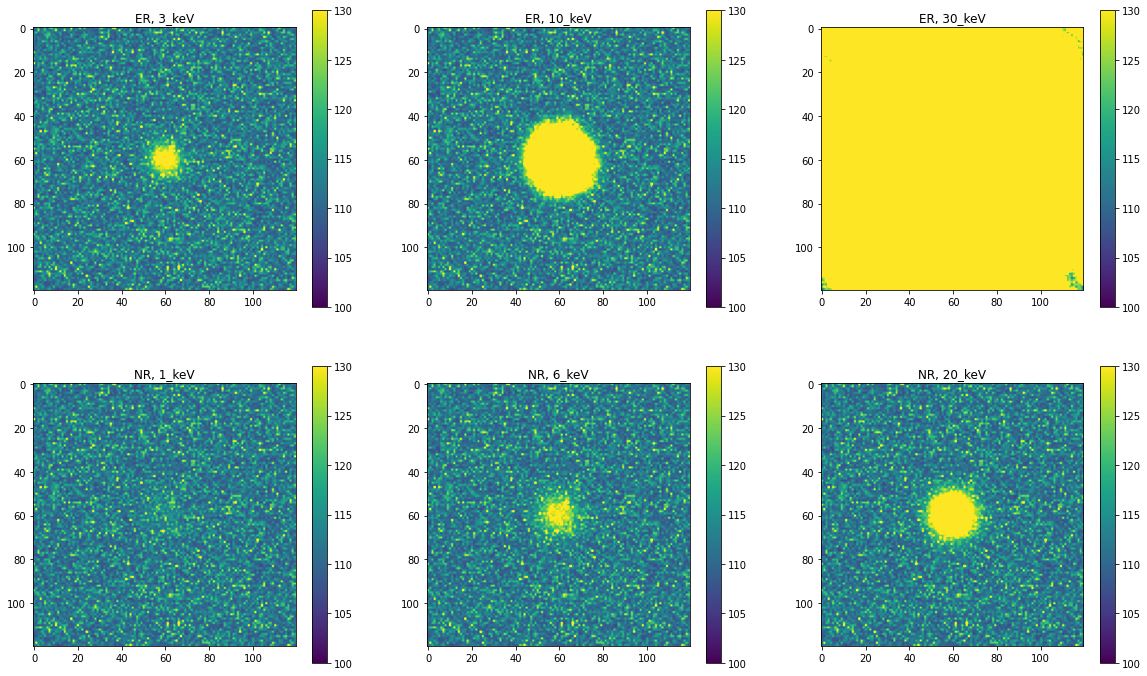

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))
for i, key in enumerate(ER_images.keys()):
    plt.subplot(2, 3, 1+i)
    plt.imshow(np.max(ER_images[key], axis=0), vmin=100, vmax=130)
    plt.colorbar()
    plt.title(f"ER, {key}")
for i, key in enumerate(NR_images.keys()):
    plt.subplot(2, 3, 4+i)
    plt.imshow(np.max(NR_images[key], axis=0), vmin=100, vmax=130)
    plt.colorbar()
    plt.title(f"NR, {key}")

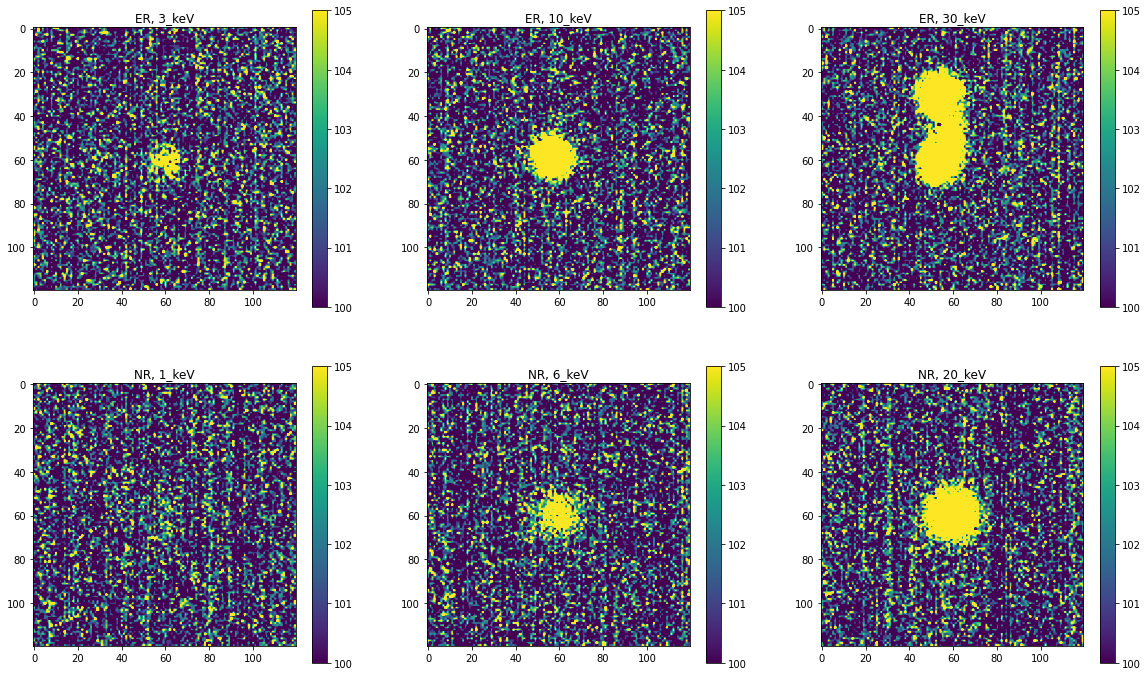

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))
for i, key in enumerate(ER_images.keys()):
    plt.subplot(2, 3, 1+i)
    plt.imshow(ER_images[key][3], vmin=100, vmax=105)
    plt.colorbar()
    plt.title(f"ER, {key}")
for i, key in enumerate(NR_images.keys()):
    plt.subplot(2, 3, 4+i)
    plt.imshow(NR_images[key][3], vmin=100, vmax=105)
    plt.colorbar()
    plt.title(f"NR, {key}")

One interesting idea here is: what if we can generate the histogram of pixel values for each image?

In [17]:
ER_histcollection = {}
NR_histcollection = {}

for key in ER_images.keys():
    ER_histcollection[key] = []
    for image in ER_images[key]:
        imagehist, _ = np.histogram(image, bins=100, range=(100, 200))
        ER_histcollection[key].append(imagehist)
    ER_histcollection[key] = np.asarray(ER_histcollection[key])
    
for key in NR_images.keys():
    NR_histcollection[key] = []
    for image in NR_images[key]:
        imagehist, _ = np.histogram(image, bins=100, range=(100, 200))
        NR_histcollection[key].append(imagehist)
    NR_histcollection[key] = np.asarray(NR_histcollection[key])

Plotting the histogram for each energy level in ER and NR.

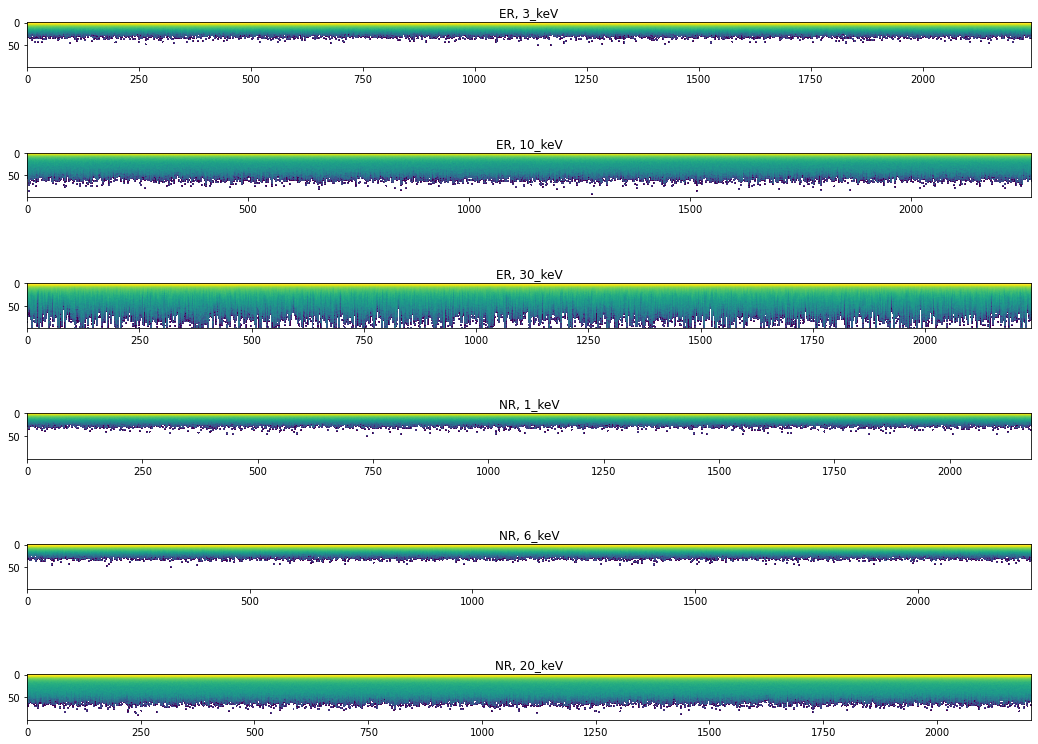

In [18]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(18, 14), facecolor="white")
for i, key in enumerate(ER_histcollection.keys()):
    plt.subplot(6, 1, i+1)
    plt.imshow(ER_histcollection[key].T, norm=LogNorm(vmin=0.01, vmax=1000))
    plt.title(f"ER, {key}")
for i, key in enumerate(NR_histcollection.keys()):
    plt.subplot(6, 1, i+4)
    plt.imshow(NR_histcollection[key].T, norm=LogNorm(vmin=0.01, vmax=1000))
    plt.title(f"NR, {key}")

If we plot the mean values of an image versus zoomed values of the same image, we can see that they are clustered in a very interesting way.

Text(0, 0.5, 'Standard deviations of pixel values')

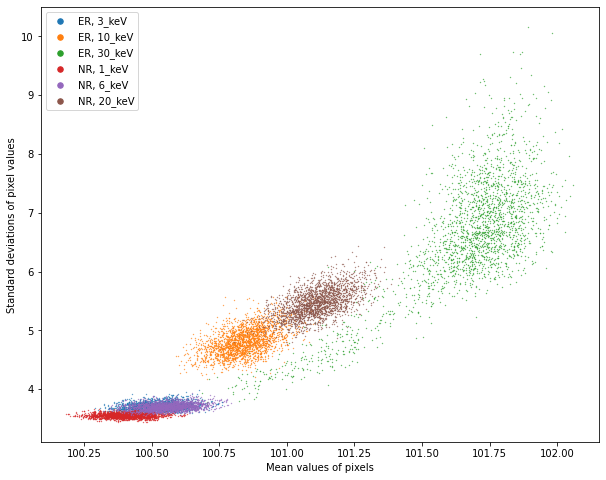

In [19]:
plt.figure(figsize=(10, 8))
for key in ER_images.keys():
    plt.scatter([np.mean(image) for image in ER_images[key]], [np.std(image) for image in ER_images[key]], \
                label=f"ER, {key}", s=0.1)
for key in NR_images.keys():
    plt.scatter([np.mean(image) for image in NR_images[key]], [np.std(image) for image in NR_images[key]], \
                label=f"NR, {key}", s=0.1)
legend = plt.legend()
for i in range(6):
    legend.legendHandles[i]._sizes = [30]
plt.xlabel("Mean values of pixels")
plt.ylabel("Standard deviations of pixel values")

Text(0, 0.5, 'Standard deviations of pixel values')

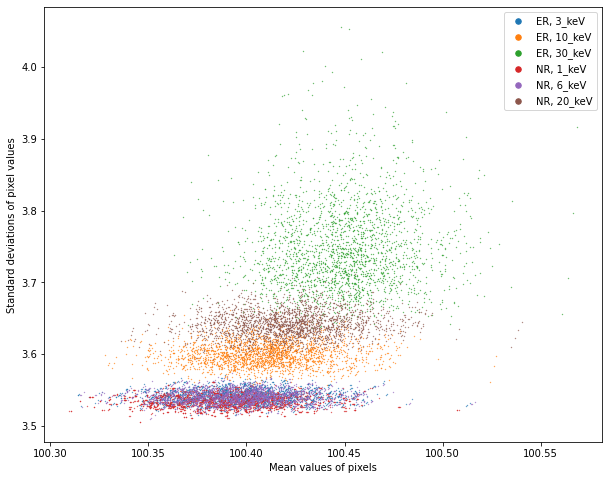

In [20]:
plt.figure(figsize=(10, 8))
for key in ER_images.keys():
    plt.scatter([np.mean(image) for image in ER_images_raw[key]], \
                [np.std(image) for image in ER_images_raw[key]], \
                label=f"ER, {key}", s=0.1)
for key in NR_images.keys():
    plt.scatter([np.mean(image) for image in NR_images_raw[key]], \
                [np.std(image) for image in NR_images_raw[key]], \
                label=f"NR, {key}", s=0.1)
legend = plt.legend()
for i in range(6):
    legend.legendHandles[i]._sizes = [30]
plt.xlabel("Mean values of pixels")
plt.ylabel("Standard deviations of pixel values")

As you can see, images with energy levels less than 10 keV clump into one group.

And yes, I use Keras. Shocker.

In [21]:
import keras
from keras.layers import Input, Dense, Reshape, Lambda, Concatenate, Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import BatchNormalization, ReLU, Dropout
from keras.models import Model
from keras.regularizers import l1_l2

For this model ensemble, I will calculate the final probability of the signal as

$$ P(E) = P(E|H)P(H) + P(E|M)P(M) + P(E|L)P(L) $$

Where E, H, M, L represents ER, high-energy levels at 20 and 30 keV, medium-energy levels at 6 and 10 keV, and low-energy levels at 1 and 3 keV respectively

In this iteration, I will also adapt the network architecture proposed by the baseline code, which gives the score of 0.94. I used to work on the network structure from scratch, and the best score I got is 0.90. I am so desperate. I want to win this. I want to break even from that 0.94 score. Please, if you are reading this, help!

In [22]:
def base_model():
    input_layer = Input((120, 120))
    reshape_layer = Reshape((120, 120, 1))(input_layer)
    conv2d_layer = BatchNormalization()(reshape_layer)
    conv2d_layer = Conv2D(16, 5, strides=1, padding="same")(conv2d_layer)
    #conv2d_layer = BatchNormalization()(conv2d_layer)
    conv2d_layer = ReLU()(conv2d_layer)
    conv2d_layer = MaxPooling2D((19, 19), strides=7)(conv2d_layer)
    conv2d_layer = Reshape((3600,))(conv2d_layer)
    
    dropout_layer = Dropout(0.5)(conv2d_layer)
    
    model_layer = Dense(50, activation="relu", kernel_regularizer=l1_l2(l1=1e-3, l2=1e-3))(dropout_layer)
    model_layer = Dense(50, activation="relu", kernel_regularizer=l1_l2(l1=1e-3, l2=1e-3))(dropout_layer)
    model_layer = Dense(50, activation="relu", kernel_regularizer=l1_l2(l1=1e-3, l2=1e-3))(dropout_layer)
    model_layer = Dense(1, activation="sigmoid")(model_layer)
    
    model = Model(inputs=[input_layer], outputs=[model_layer])
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [23]:
base_model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120)]        0         
_________________________________________________________________
reshape (Reshape)            (None, 120, 120, 1)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 120, 120, 1)       4         
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 120, 16)      416       
_________________________________________________________________
re_lu (ReLU)                 (None, 120, 120, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 3600)              0     

In [24]:
X_ER_if_high_train = np.concatenate([ER_images["30_keV"][:1500], NR_images["20_keV"][:1500], ER_images["10_keV"][:1500]])
X_ER_if_high_test  = np.concatenate([ER_images["30_keV"][1500:], NR_images["20_keV"][1500:], ER_images["10_keV"][1500:]])

y_ER_if_high_train = np.concatenate([ER_target["30_keV"][:1500], NR_target["20_keV"][:1500], ER_target["10_keV"][:1500]])
y_ER_if_high_test  = np.concatenate([ER_target["30_keV"][1500:], NR_target["20_keV"][1500:], ER_target["10_keV"][1500:]])

In [25]:
y_ER_if_high_train.shape

(4500,)

In [26]:
model_ER_if_high = base_model()

model_ER_if_high.fit(X_ER_if_high_train, y_ER_if_high_train, epochs=10, \
                     validation_data=(X_ER_if_high_test, y_ER_if_high_test))

Epoch 1/10
141/141 [==============================] - 38s 259ms/step - loss: 3.1654 - accuracy: 0.7740 - val_loss: 5.4239 - val_accuracy: 0.6806
Epoch 2/10
141/141 [==============================] - 37s 261ms/step - loss: 1.0727 - accuracy: 0.8977 - val_loss: 0.6592 - val_accuracy: 0.9671
Epoch 3/10
141/141 [==============================] - 36s 259ms/step - loss: 0.6191 - accuracy: 0.9386 - val_loss: 0.3724 - val_accuracy: 0.9865
Epoch 4/10
141/141 [==============================] - 36s 256ms/step - loss: 0.3916 - accuracy: 0.9599 - val_loss: 0.3897 - val_accuracy: 0.9247
Epoch 5/10
141/141 [==============================] - 36s 253ms/step - loss: 0.3238 - accuracy: 0.9618 - val_loss: 0.2790 - val_accuracy: 0.9973
Epoch 6/10
141/141 [==============================] - 35s 250ms/step - loss: 0.2905 - accuracy: 0.9738 - val_loss: 0.2104 - val_accuracy: 0.9955
Epoch 7/10
141/141 [==============================] - 36s 253ms/step - loss: 0.2175 - accuracy: 0.9859 - val_loss: 0.2223 - val_ac

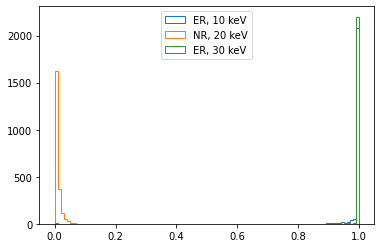

In [27]:
plt.hist(model_ER_if_high.predict(ER_images["10_keV"]), \
         range=(0, 1), bins=100, label="ER, 10 keV", histtype="step")
plt.hist(model_ER_if_high.predict(NR_images["20_keV"]), \
         range=(0, 1), bins=100, label="NR, 20 keV", histtype="step")
plt.hist(model_ER_if_high.predict(ER_images["30_keV"]), \
         range=(0, 1), bins=100, label="ER, 30 keV", histtype="step")
plt.legend(loc="upper center");

In [28]:
X_ER_if_low_train = np.concatenate([ER_images["3_keV"][:1500], NR_images["1_keV"][:1500], \
                                    NR_images["6_keV"][:1500], ER_images["3_keV"][:1500]])
X_ER_if_low_test  = np.concatenate([ER_images["3_keV"][1500:], NR_images["1_keV"][1500:], \
                                    NR_images["6_keV"][1500:], ER_images["3_keV"][1500:]])

y_ER_if_low_train = np.concatenate([ER_target["3_keV"][:1500], NR_target["1_keV"][:1500], \
                                    NR_target["6_keV"][:1500], ER_target["3_keV"][:1500]])
y_ER_if_low_test  = np.concatenate([ER_target["3_keV"][1500:], NR_target["1_keV"][1500:], \
                                    NR_target["6_keV"][1500:], ER_target["3_keV"][1500:]])

In [29]:
model_ER_if_low = base_model()

model_ER_if_low.fit(X_ER_if_low_train, y_ER_if_low_train, epochs=5, \
                    validation_data=(X_ER_if_low_test, y_ER_if_low_test))

Epoch 1/5
188/188 [==============================] - 48s 252ms/step - loss: 3.5014 - accuracy: 0.5602 - val_loss: 3.8789 - val_accuracy: 0.4907
Epoch 2/5
188/188 [==============================] - 49s 263ms/step - loss: 0.8791 - accuracy: 0.8421 - val_loss: 0.8592 - val_accuracy: 0.6833
Epoch 3/5
188/188 [==============================] - 47s 250ms/step - loss: 0.3754 - accuracy: 0.9293 - val_loss: 0.2219 - val_accuracy: 0.9767
Epoch 4/5
188/188 [==============================] - 47s 249ms/step - loss: 0.2748 - accuracy: 0.9498 - val_loss: 0.2099 - val_accuracy: 0.9822
Epoch 5/5
188/188 [==============================] - 47s 251ms/step - loss: 0.2825 - accuracy: 0.9502 - val_loss: 0.1750 - val_accuracy: 0.9856


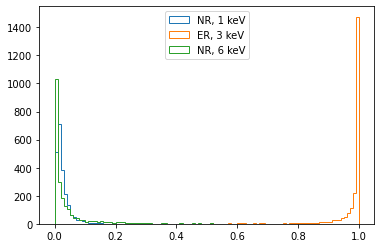

In [30]:
plt.hist(model_ER_if_low.predict(NR_images["1_keV"]), \
         range=(0, 1), bins=100, label="NR, 1 keV", histtype="step")
plt.hist(model_ER_if_low.predict(ER_images["3_keV"]), \
         range=(0, 1), bins=100, label="ER, 3 keV", histtype="step")
plt.hist(model_ER_if_low.predict(NR_images["6_keV"]), \
         range=(0, 1), bins=100, label="NR, 6 keV", histtype="step")
plt.legend(loc="upper center");

In [31]:
X_high_or_low_train = np.concatenate([NR_images["1_keV"][:1500], ER_images["3_keV"][:1500], \
                                      NR_images["6_keV"][:1500], ER_images["10_keV"][:1500], \
                                      NR_images["20_keV"][:1500], ER_images["30_keV"][:1500], \
                                      ])
X_high_or_low_test  = np.concatenate([NR_images["1_keV"][1500:], ER_images["3_keV"][1500:], \
                                      NR_images["6_keV"][1500:], ER_images["10_keV"][1500:], \
                                      NR_images["20_keV"][1500:], ER_images["30_keV"][1500:], \
                                      ])

y_high_or_low_train = np.concatenate([[0]*4500, [1]*4500])
y_high_or_low_test  = np.concatenate([[0]*(len(NR_images["1_keV"])+len(ER_images["3_keV"])\
                                           +len(NR_images["6_keV"])-4500), \
                                      [1]*(len(ER_images["10_keV"])+len(NR_images["20_keV"])\
                                           +len(ER_images["30_keV"])-4500)])

In [32]:
input_layer = Input((120, 120))
reshape_layer = Reshape((120, 120, 1))(input_layer)
conv2d_layer = AveragePooling2D((5, 5))(reshape_layer)
conv2d_layer = BatchNormalization()(conv2d_layer)
conv2d_layer = Conv2D(16, 5, strides=1, padding="same")(conv2d_layer)
conv2d_layer = ReLU()(conv2d_layer)
conv2d_layer = MaxPooling2D((4, 4))(conv2d_layer)
conv2d_layer = Reshape((576,))(conv2d_layer)

dropout_layer = Dropout(0.2)(conv2d_layer)

model_layer = Dense(50, activation="relu", kernel_regularizer=l1_l2(l1=1e-3, l2=1e-3))(dropout_layer)
model_layer = Dense(50, activation="relu", kernel_regularizer=l1_l2(l1=1e-3, l2=1e-3))(model_layer)
model_layer = Dense(50, activation="relu", kernel_regularizer=l1_l2(l1=1e-3, l2=1e-3))(model_layer)
model_layer = Dense(1, activation="sigmoid")(model_layer)

model_high_or_low = Model(inputs=[input_layer], outputs=[model_layer])
model_high_or_low.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_high_or_low.fit(X_high_or_low_train, y_high_or_low_train, epochs=10, \
                    validation_data=(X_high_or_low_test, y_high_or_low_test))

Epoch 1/10
282/282 [==============================] - 8s 25ms/step - loss: 1.4946 - accuracy: 0.8979 - val_loss: 12.8182 - val_accuracy: 0.5048
Epoch 2/10
282/282 [==============================] - 7s 24ms/step - loss: 0.2262 - accuracy: 0.9968 - val_loss: 0.1449 - val_accuracy: 1.0000
Epoch 3/10
282/282 [==============================] - 7s 25ms/step - loss: 0.1418 - accuracy: 0.9942 - val_loss: 0.0874 - val_accuracy: 0.9998
Epoch 4/10
282/282 [==============================] - 7s 24ms/step - loss: 0.0900 - accuracy: 0.9986 - val_loss: 0.0662 - val_accuracy: 1.0000
Epoch 5/10
282/282 [==============================] - 7s 25ms/step - loss: 0.0689 - accuracy: 0.9993 - val_loss: 0.0570 - val_accuracy: 1.0000
Epoch 6/10
282/282 [==============================] - 7s 24ms/step - loss: 0.0586 - accuracy: 0.9987 - val_loss: 0.0460 - val_accuracy: 1.0000
Epoch 7/10
282/282 [==============================] - 7s 25ms/step - loss: 0.0488 - accuracy: 0.9986 - val_loss: 0.0418 - val_accuracy: 1.000

The prediction between high energy and low energy datasets look good.

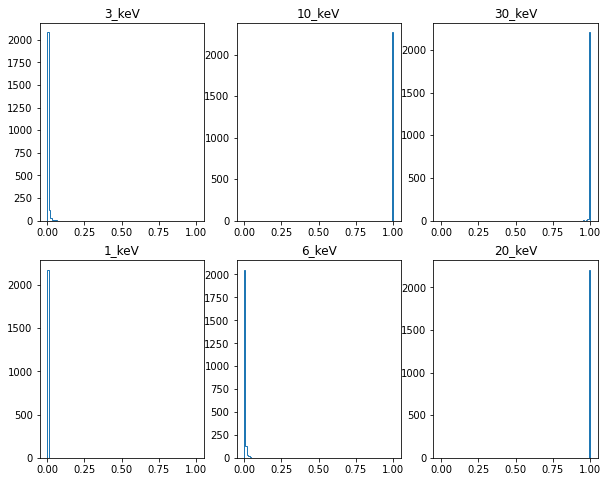

In [33]:
plt.figure(figsize=(10, 8))
for i, key in enumerate(ER_images.keys()):
    plt.subplot(2, 3, i+1)
    plt.hist(model_high_or_low.predict(ER_images[key]), \
             bins=100, range=(0, 1), \
             histtype="step", label=key)
    plt.title(key)
for i, key in enumerate(NR_images.keys()):
    plt.subplot(2, 3, i+4)
    plt.hist(model_high_or_low.predict(NR_images[key]), \
             bins=100, range=(0, 1), \
             histtype="step", label=key)
    plt.title(key)

And the final prediction is good too, at least for the dataset that we have.

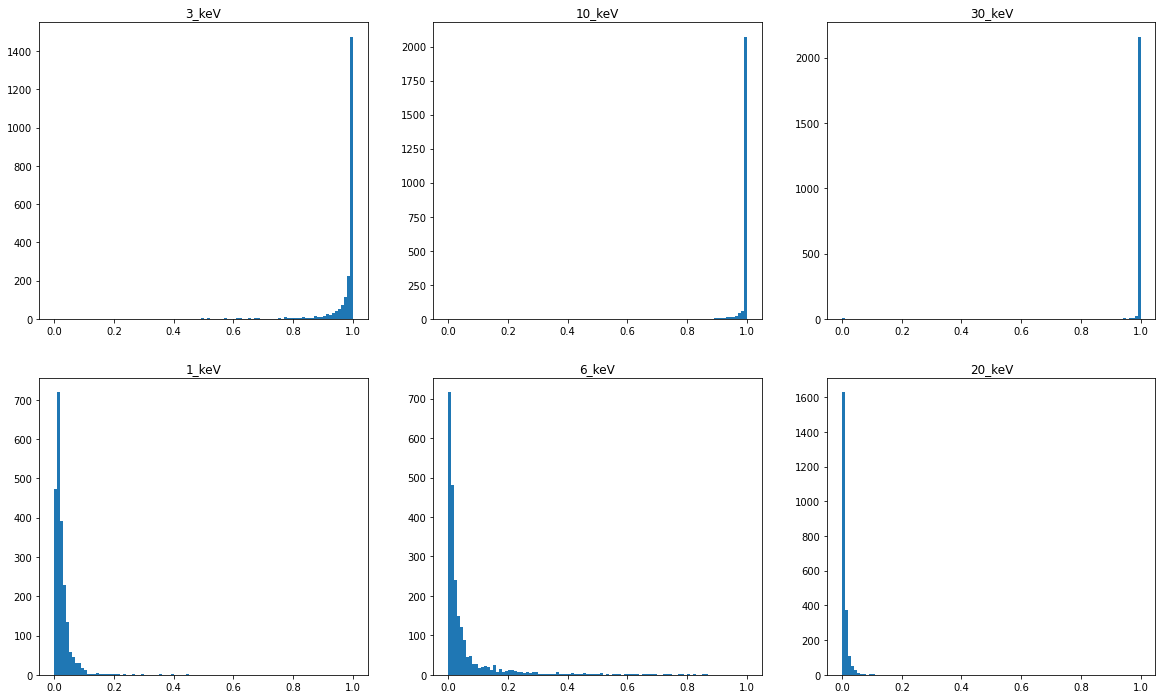

In [34]:
plt.figure(figsize=(20, 12), facecolor="white")
for imgcol, imgcolzoomed, imgcolzoomed2 in zip([ER_images, NR_images], \
                                               [ER_images_zoomed1, NR_images_zoomed1], \
                                               [ER_images_zoomed2, NR_images_zoomed2]):
    for key in imgcol.keys():
        P_ER_if_high = model_ER_if_high.predict(imgcol[key]).flatten()
        #P_ER_if_med  = model_ER_if_med.predict(imgcol[key]).flatten()
        P_ER_if_low  = model_ER_if_low.predict(imgcol[key]).flatten()
        P_high_or_low = model_high_or_low.predict(imgcol[key]).flatten()
        final_discrim = P_ER_if_high*P_high_or_low + P_ER_if_low*(1-P_high_or_low)
        if key in ER_images.keys():
            plt.subplot(2, 3, 1+list(ER_images.keys()).index(key))
        else:
            plt.subplot(2, 3, 4+list(NR_images.keys()).index(key))
        plt.hist(final_discrim, bins=100, range=(0, 1))
        plt.title(key)

Since the training dataset contains some ER and NR images from unknown energy levels, we can use them to check the performance of our model.

In [35]:
ER_test = []
for energy in ["1_keV", "6_keV", "20_keV"]:
    print(energy, len(glob.glob(f"/kaggle/working/train/ER/*{energy}*.png")))
    for filepath in glob.glob(f"/kaggle/working/train/ER/*{energy}*.png"):
        image_hist = imageio.imread(filepath)[228:348, 228:348]
        ER_test.append(image_hist)
ER_test = np.asarray(ER_test)

1_keV 3
6_keV 1
20_keV 2


In [36]:
NR_test = []
for energy in ["3_keV", "10_keV", "30_keV"]:
    print(energy, len(glob.glob(f"/kaggle/working/train/NR/*{energy}*.png")))
    for filepath in glob.glob(f"/kaggle/working/train/NR/*{energy}*.png"):
        image_hist = imageio.imread(filepath)[228:348, 228:348]
        NR_test.append(image_hist)
NR_test = np.asarray(NR_test)

3_keV 2
10_keV 2
30_keV 2


In [37]:
def predict_final_discrim(data):
    P_ER_if_high = model_ER_if_high.predict(data).flatten()
    P_ER_if_low  = model_ER_if_low.predict(data).flatten()
    P_high_or_low = model_high_or_low.predict(data).flatten()
    final_discrim = P_ER_if_high*P_high_or_low + P_ER_if_low*(1-P_high_or_low)
    return P_ER_if_high, P_ER_if_low, P_high_or_low, final_discrim

In [38]:
ER_ER_if_high_test, ER_ER_if_low_test, ER_high_or_low_test, ER_final_test = \
predict_final_discrim(ER_test)

In [39]:
NR_ER_if_high_test, NR_ER_if_low_test, NR_high_or_low_test, NR_final_test = \
predict_final_discrim(NR_test)

The results are very worrying for low energies of ER. Basically, the network that is responsible for classifying ER and NR at low energies are confused when given ER images at 1 keV. The network that determines the energy level can correctly perform its job.

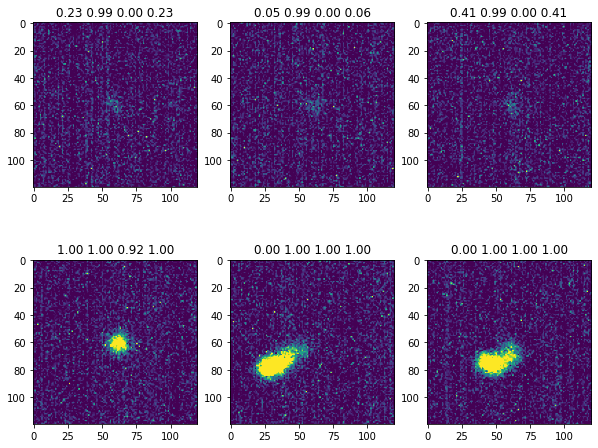

In [40]:
plt.figure(figsize=(10, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(ER_test[i], vmin=100, vmax=120)
    plt.title(f"{ER_ER_if_low_test[i]:.2f} {ER_ER_if_high_test[i]:.2f} " \
              + f"{ER_high_or_low_test[i]:.2f} {ER_final_test[i]:.2f}")

And the network that is responsible for medium-level energies seemed to be confused.

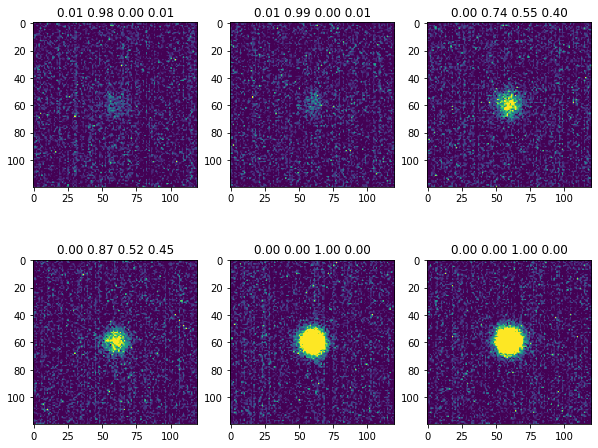

In [41]:
plt.figure(figsize=(10, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(NR_test[i], vmin=100, vmax=120)
    plt.title(f"{NR_ER_if_low_test[i]:.2f} {NR_ER_if_high_test[i]:.2f} " \
              + f"{NR_high_or_low_test[i]:.2f} {NR_final_test[i]:.2f}")

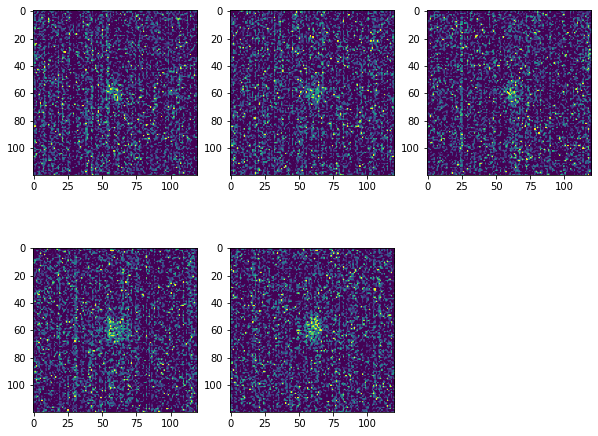

In [42]:
plt.figure(figsize=(10, 8))
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(ER_test[i], vmin=100, vmax=110)
for i in range(2):
    plt.subplot(2, 3, i+4)
    plt.imshow(NR_test[i], vmin=100, vmax=110)

Now let's extract the testing dataset.

In [43]:
os.system("tar -xvf /kaggle/input/mlhep2021-classification/MLHEP-2021-test.tar.xz")

0

Peeking into the files in testing dataset, I noticed that the file names are simply IDs from `classification_example`.

In [44]:
import os
for dirname, _, filenames in os.walk('/kaggle/working/test'):
    for filename in filenames[:5]:
        print(os.path.join(dirname, filename))

/kaggle/working/test/67c5eb4ce7631bdf54eec74a6abdf1919a5a879b.png
/kaggle/working/test/8357fd520ed4f6f051e099108219e7a1c2cf9f20.png
/kaggle/working/test/d7f6bf271c03f04e3676502bacf2224be828dbcd.png
/kaggle/working/test/9fc278f285e15f46e1e325945318061ef3ccca78.png
/kaggle/working/test/8cf07a34b388dfbc33a5bdb7bf21f723768b3c1d.png


In [45]:
classification_example.head()

,id,particle
0,9a8b8bfc7a06afd346ff1c88f1f7a03316a9bc76,0.374540
1,2caa5748f814bbdbc64f4db43d7412ce359a777b,0.950714
2,b879970a23fc2a3b093bce85096808f13eaa69fb,0.731994
3,a4d3cb5abbdc11518bb67ae7f2c415de808effb3,0.598658
4,df8de9207196305057f73cea03d265ba720cb6e1,0.156019


There are 16560 images in the testing dataset.

In [46]:
ls test/*.png | wc -l

16560


This number matches the shape of `classification_example` dataframe. I wonder why.

In [47]:
classification_example.shape

(16560, 2)

Now let's calculate the predictions for each testing image.

In [48]:
test_image_collection = []
for filepath in tqdm.tqdm(glob.glob("/kaggle/working/test/*.png")):
    image_hist = imageio.imread(filepath)[228:348, 228:348]
    test_image_collection.append(image_hist)
test_image_collection = np.asarray(test_image_collection)

100%|██████████| 16560/16560 [01:17<00:00, 214.47it/s]


In [49]:
inputs = [test_image_collection]
P_ER_if_high  =  model_ER_if_high.predict(inputs).flatten()
P_ER_if_low   =  model_ER_if_low.predict(inputs).flatten()
P_high_or_low = model_high_or_low.predict(inputs).flatten()
final_discrim = P_ER_if_high*P_high_or_low + P_ER_if_low*(1-P_high_or_low)

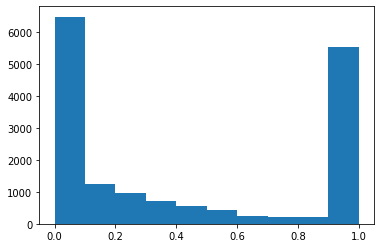

In [50]:
plt.hist(final_discrim, range=(0, 1), bins=10);

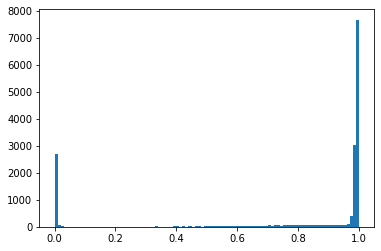

In [51]:
plt.hist(P_ER_if_high, range=(0, 1), bins=100);

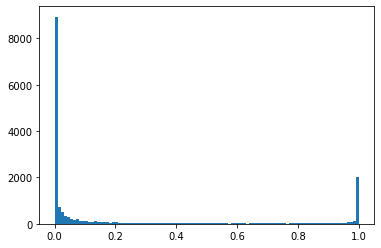

In [52]:
plt.hist(P_ER_if_low, range=(0, 1), bins=100);

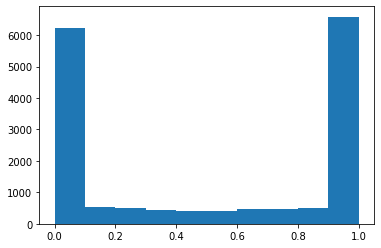

In [53]:
plt.hist(P_high_or_low, range=(0, 1), bins=10);

Let's construct the new dataframe.

In [54]:
classification_answer = pd.DataFrame(columns=["id", "particle"])

In [55]:
classification_answer["id"] = [os.path.splitext(os.path.basename(path))[0] \
                               for path in glob.glob("/kaggle/working/test/*.png")]

In [56]:
classification_answer["particle"] = final_discrim

In [57]:
classification_answer.head()

,id,particle
0,67c5eb4ce7631bdf54eec74a6abdf1919a5a879b,0.996263
1,8357fd520ed4f6f051e099108219e7a1c2cf9f20,0.044143
2,d7f6bf271c03f04e3676502bacf2224be828dbcd,0.000119
3,9fc278f285e15f46e1e325945318061ef3ccca78,0.797935
4,8cf07a34b388dfbc33a5bdb7bf21f723768b3c1d,0.021585


In [58]:
classification_answer.shape

(16560, 2)

The distribution of answers from the test dataset looks good.

<AxesSubplot:ylabel='Frequency'>

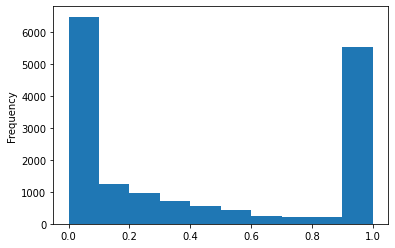

In [59]:
classification_answer["particle"].plot.hist(bins=10)

A quick check shows that there are no NaN in the particle column after the prediction above.

In [60]:
classification_answer["particle"].isnull().values.any()

False

To comply with the requirements from the competition, I need to assign the id column as index.

In [61]:
classification_answer = classification_answer.set_index("id")

In [62]:
classification_answer

,particle
id,
67c5eb4ce7631bdf54eec74a6abdf1919a5a879b,0.996263
8357fd520ed4f6f051e099108219e7a1c2cf9f20,0.044143
d7f6bf271c03f04e3676502bacf2224be828dbcd,0.000119
9fc278f285e15f46e1e325945318061ef3ccca78,0.797935
8cf07a34b388dfbc33a5bdb7bf21f723768b3c1d,0.021585
...,...
af7ec124fd867a9e234c11ab11b24e2fc3faa862,0.406648
d2b24dd080ab1a0c5e187b4fe6a5a4aa259859ab,1.000000
d7f81f322337d42037080114b691ce401c423dcd,0.000027


Some cleanup

In [63]:
os.system("rm /kaggle/working/test/*")
os.system("rm -r /kaggle/working/train/*")

0

And now time to save the prediction file for the competition! Wish me luck! 🤞🏼

In [64]:
classification_answer.to_csv("particle_prediction_submission.csv")